In [1]:
# ===============================================================
# Imports
# ===============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC

from sklearn.base import TransformerMixin, BaseEstimator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


2025-11-27 14:34:44.205543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 14:34:44.239923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 14:34:45.076780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# ===============================================================
# Load data
# ===============================================================

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# train = train.dropna(subset=["spend_category"])#some columns had null!

# y.isna().sum()
# y.shape
(train["spend_category"].isna().sum()/train.shape[0] )*100

np.float64(0.2686897423739529)

In [3]:
train.columns[train.isna().sum()!=0]

Index(['country', 'age_group', 'travel_companions', 'num_females', 'num_males',
       'main_activity', 'is_first_visit', 'intl_transport_included',
       'accomodation_included', 'food_included', 'insurance_included',
       'days_booked_before_trip', 'arrival_weather', 'total_trip_days',
       'has_special_requirements', 'spend_category'],
      dtype='object')

In [4]:
train.dtypes

trip_id                         object
country                         object
age_group                       object
travel_companions               object
num_females                    float64
num_males                      float64
main_activity                   object
visit_purpose                   object
is_first_visit                  object
mainland_stay_nights             int64
island_stay_nights               int64
tour_type                       object
intl_transport_included         object
info_source                     object
accomodation_included           object
food_included                   object
domestic_transport_included     object
sightseeing_included            object
guide_included                  object
insurance_included              object
days_booked_before_trip         object
arrival_weather                 object
total_trip_days                 object
has_special_requirements        object
spend_category                 float64
dtype: object

In [5]:
train[["mainland_stay_nights","island_stay_nights","total_trip_days"]]

,mainland_stay_nights,island_stay_nights,total_trip_days
0,0,7,30+
1,6,0,30+
2,4,2,30+
3,0,7,NaN
4,0,7,7-14
...,...,...,...
12649,7,0,30+
12650,10,0,7-14
12651,9,0,1-6
12652,7,7,7-14


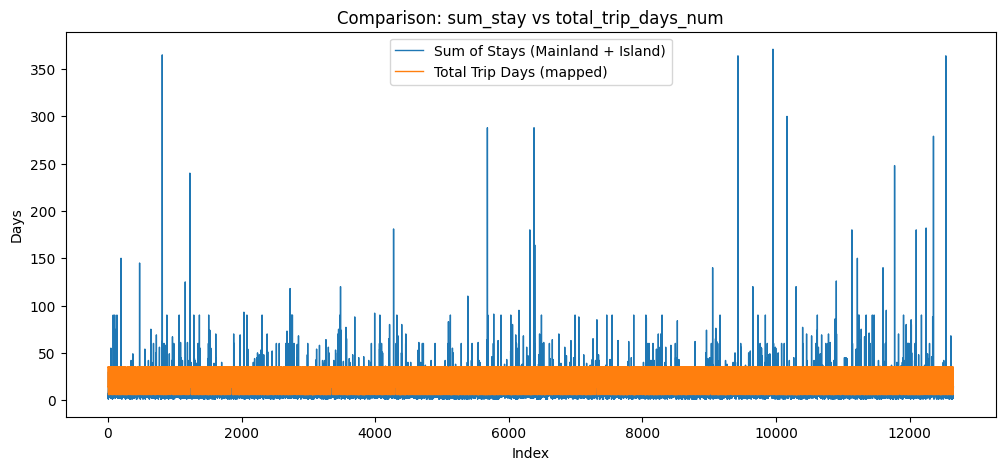

In [6]:
import matplotlib.pyplot as plt

# Map categories → approximate numeric values
mapping = {
    "1-6": 6,
    "7-14": 14,
    "15-30": 30,
    "30+": 35
}

train["total_trip_days_num"] = train["total_trip_days"].map(mapping)

# Compute mainland + island stay
train["sum_stay"] = train["mainland_stay_nights"] + train["island_stay_nights"]

# Plot the lines
plt.figure(figsize=(12,5))

plt.plot(train.index, train["sum_stay"], label="Sum of Stays (Mainland + Island)", linewidth=1)
plt.plot(train.index, train["total_trip_days_num"], label="Total Trip Days (mapped)", linewidth=1)

plt.legend()
plt.xlabel("Index")
plt.ylabel("Days")
plt.title("Comparison: sum_stay vs total_trip_days_num")
plt.show()


In [7]:
train.describe()


,num_females,num_males,mainland_stay_nights,island_stay_nights,spend_category,total_trip_days_num,sum_stay
count,12652.000000,12650.000000,12654.000000,12654.000000,12620.000000,12252.000000,12654.000000
mean,0.943724,1.009407,9.205073,2.516833,0.621157,21.048400,11.721906
std,1.268167,1.234850,14.548536,5.132266,0.683645,11.796254,14.916741
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,1.000000,3.000000,0.000000,0.000000,14.000000,5.000000
50%,1.000000,1.000000,6.000000,0.000000,1.000000,14.000000,8.000000
75%,1.000000,1.000000,11.000000,4.000000,1.000000,35.000000,14.000000
max,49.000000,58.000000,365.000000,240.000000,2.000000,35.000000,371.000000
